# CS7641 Asignment 1 Titanic dataset

by Varant Arabian (varabian3)

In [ ]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
!mkdir -p plots
!mkdir -p plots/titanic
!mkdir -p plots/breast_cancer

# Import dependencies

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, validation_curve, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.datasets import load_breast_cancer

from IPython.display import clear_output 

sns.set_theme(style="darkgrid")

# Titanic dataset

In [ ]:
dataset_name = "titanic"

### Load data

| variable | definition |
| --- | --- |
| survival | Survival |
| pclass | ticket class |
| age | age in years |
| sibsp | # of siblings on board |
| parch | # of parents/children on board |
| ticket | ticket number |
| fare | passenger fare |
| cabin | cabin number |
| embarked | port of embarkation |

download the data

In [ ]:
!mkdir -p data/titanic
!curl https://raw.githubusercontent.com/avarant/cs7641-assignment1/master/data/titanic/train.csv > /content/data/titanic/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60302  100 60302    0     0   420k      0 --:--:-- --:--:-- --:--:--  420k


In [ ]:
path_to_csv = "/content/data/titanic/train.csv"

In [ ]:
df = pd.read_csv(path_to_csv)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

0.383838 percent survived. 

## Preprocess

drop features



In [ ]:
df = df.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1)

impute missing values

In [ ]:
mean_age = df["Age"].mean()
df["Age"].fillna(mean_age, inplace=True)

In [ ]:
df[df['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


combine features

combine SibSp (# of siblings on board) and Parch (# of parent/children on board) into a famly size feature

In [ ]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(["SibSp", "Parch"], axis=1)
# df

one-hot encode

convert categorial features to one-hot encoding

In [ ]:
# # encode categorial labels as ordinal
# le = LabelEncoder()
# df = df.apply(LabelEncoder().fit_transform)
# df

one-hot encode Sex

In [ ]:
df['Sex_F'] = (df['Sex'] == 'female').astype(int)
df['Sex_M'] = (df['Sex'] == 'male').astype(int)
df = df.drop(["Sex"], axis=1)
# df

one-hot encode Embarked

In [ ]:
df['Embarked_S'] = (df['Embarked'] == 'S').astype(int)
df['Embarked_C'] = (df['Embarked'] == 'C').astype(int)
df['Embarked_Q'] = (df['Embarked'] == 'Q').astype(int)
df = df.drop(["Embarked"], axis=1)
# df

bin features

convert continuous numerical features to ordinal

bin fare

In [ ]:
df['FareBand'] = pd.qcut(df['Fare'], 4)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [ ]:
df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
df.loc[ df['Fare'] > 31, 'Fare'] = 3
df['Fare'] = df['Fare'].astype(int)
df = df.drop(['FareBand'], axis=1)
# df

bin age

In [ ]:
df['AgeBand'] = pd.cut(df['Age'], 5)
df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [ ]:
df.loc[ df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[ df['Age'] > 64, 'Age'] = 4
df['Age'] = df['Age'].astype(int)

df = df.drop(['AgeBand'], axis=1)
# df

scale

In [ ]:
scaler = StandardScaler()

y = (df['Survived']).values
X = (df.drop(['Survived'], axis=1)).values

X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = (df.drop(['Survived'], axis=1)).columns
X.head()

,Pclass,Age,Fare,FamilySize,Sex_F,Sex_M,Embarked_S,Embarked_C,Embarked_Q
0,0.827377,-0.357914,-1.346777,0.059160,-0.737695,0.737695,0.619306,-0.482043,-0.307562
1,-1.566107,0.873365,1.337738,0.059160,1.355574,-1.355574,-1.614710,2.074505,-0.307562
2,0.827377,-0.357914,-0.451938,-0.560975,1.355574,-1.355574,0.619306,-0.482043,-0.307562
3,-1.566107,0.873365,1.337738,0.059160,1.355574,-1.355574,0.619306,-0.482043,-0.307562
4,0.827377,0.873365,-0.451938,-0.560975,-0.737695,0.737695,0.619306,-0.482043,-0.307562


plot distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb42c8daf10>,
      dtype=object)

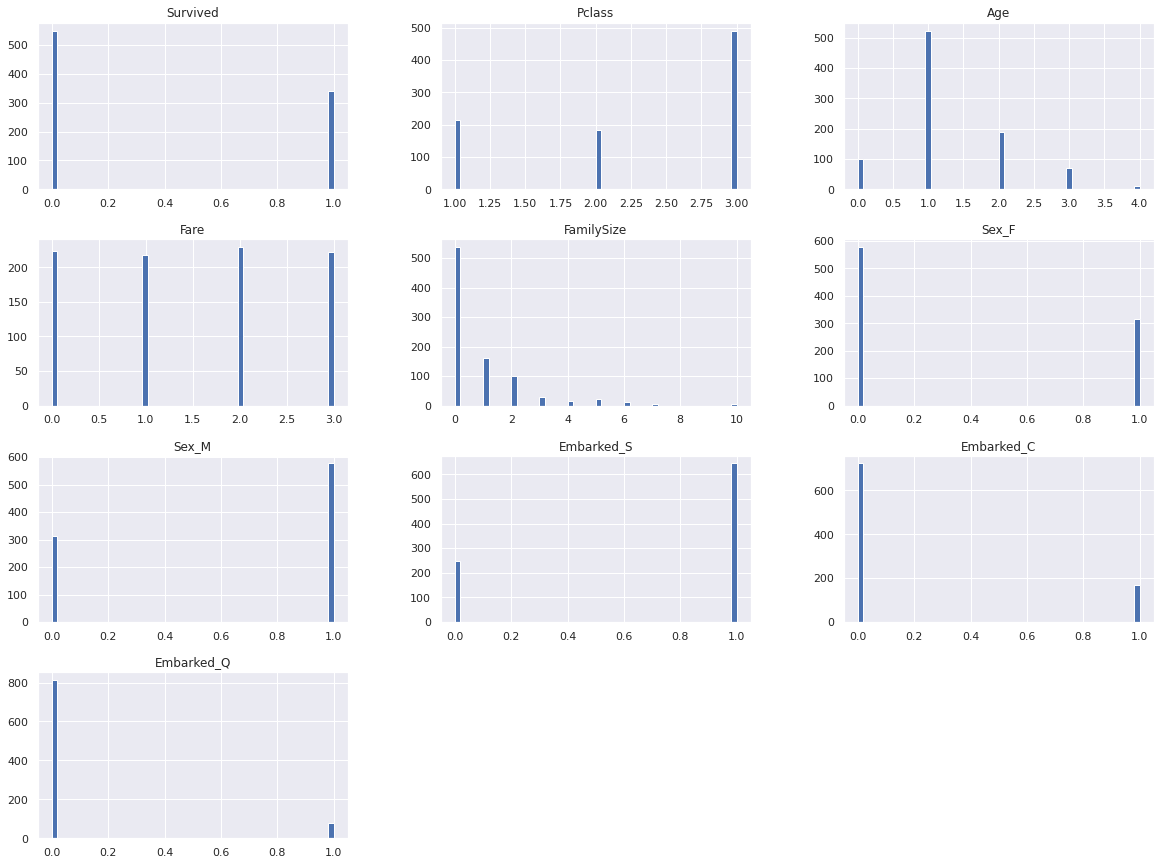

In [ ]:
df.hist(bins=50, figsize=(20,15))

show correlation

In [ ]:
corr = df.corr()
corr

,Survived,Pclass,Age,Fare,FamilySize,Sex_F,Sex_M,Embarked_S,Embarked_C,Embarked_Q
Survived,1.000000,-0.338481,-0.043800,0.295875,0.016639,0.543351,-0.543351,-0.155660,0.168240,0.003650
Pclass,-0.338481,1.000000,-0.358769,-0.628459,0.065997,-0.131900,0.131900,0.081720,-0.243292,0.221009
Age,-0.043800,-0.358769,1.000000,0.096691,-0.217063,-0.070220,0.070220,0.014816,0.032379,-0.080572
Fare,0.295875,-0.628459,0.096691,1.000000,0.465815,0.248940,-0.248940,-0.029734,0.200659,-0.242653
FamilySize,0.016639,0.065997,-0.217063,0.465815,1.000000,0.200988,-0.200988,0.079977,-0.046215,-0.058592
Sex_F,0.543351,-0.131900,-0.070220,0.248940,0.200988,1.000000,-1.000000,-0.125722,0.082853,0.074115
Sex_M,-0.543351,0.131900,0.070220,-0.248940,-0.200988,-1.000000,1.000000,0.125722,-0.082853,-0.074115
Embarked_S,-0.155660,0.081720,0.014816,-0.029734,0.079977,-0.125722,0.125722,1.000000,-0.778359,-0.496624
Embarked_C,0.168240,-0.243292,0.032379,0.200659,-0.046215,0.082853,-0.082853,-0.778359,1.000000,-0.148258
Embarked_Q,0.003650,0.221009,-0.080572,-0.242653,-0.058592,0.074115,-0.074115,-0.496624,-0.148258,1.000000


## Split into train and test

70/30 split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y
)
print(X_train.shape, X_test.shape)

(623, 9) (268, 9)


In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([165, 103]))

# Define methods and variables

In [ ]:
K_FOLDS = 10

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    save_as=None
):
    ax = plt.gca()

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")

    if save_as:
        plt.savefig(save_as)

    return plt

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_fit_time_vs_score(
    estimator,
    X,
    y,
    title="Performance of the model",
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    save_as=None
):
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    ax = plt.gca()

    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    ax.plot(fit_time_sorted, test_scores_mean_sorted, "o-")

    ax.set_xlabel("fit_times")
    ax.set_ylabel("Score")
    ax.set_title(title)

    if save_as:
        plt.savefig(save_as)

    return plt

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
def plot_validation_curve(
    estimator,
    title,
    X,
    y,
    param_name,
    param_range,
    ylim=None,
    cv=None,
    use_semilogx=False,
    save_as=None
):
    train_scores, valid_scores = validation_curve(
        estimator, 
        X, 
        y, 
        param_name=param_name, 
        param_range=param_range,
        cv=cv
    )

    clear_output()

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")

    if ylim is not None:
        plt.ylim(*ylim)
    else:
        plt.ylim(0.0, 1.1)

    lw = 2

    if not use_semilogx:
        plt.plot(
            param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
        )
        plt.plot(
            param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
        )
    else:
        plt.semilogx(
            param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
        )
        plt.semilogx(
            param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
        )

    plt.legend(loc="best")

    if save_as:
        plt.savefig(save_as)

    return plt

In [ ]:
def find_best_params(estimator, X_train, y_train, param_grid, scoring_metric='accuracy', cv=10):
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring_metric, cv=cv)
    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_
    best_result = grid_search.best_score_

    # clear output
    from IPython.display import clear_output 
    clear_output()

    print("Best parameters", grid_search.best_params_)
    print("Training accuracy:", clf.score(X_train, y_train))
    print("Cross-validation accuracy:", best_result)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")

    # print()
    # print(results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]])

    return grid_search, results_df

In [ ]:
def train_and_test(estimator):
    estimator = KNeighborsClassifier(n_neighbors=11, metric='manhattan')

    start = time.time()
    dtree = estimator.fit(X_train, y_train)
    end = time.time()
    print("training time in seconds", end - start)

    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"test accuracy: {acc}")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print("Confusion matrix:")
    print(cm)

# Support Vector Machine

In [ ]:
# param_grid = [
#     {
#         'kernel': ['rbf'],
#         'C': [0.1, 1, 10, 100, 1000, 10000],
#         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
#     },
#     {
#         'kernel': ['poly'],
#         'C': [0.1, 1, 10, 100, 1000, 10000],
#         "degree": [2, 3, 4]
#     }
# ]

# grid_search, results_df = find_best_params(SVC(), X_train, y_train, param_grid, cv=K_FOLDS)
# results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

## Poly Kernel

Tune the hyperparameter C, the regularization parameter

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

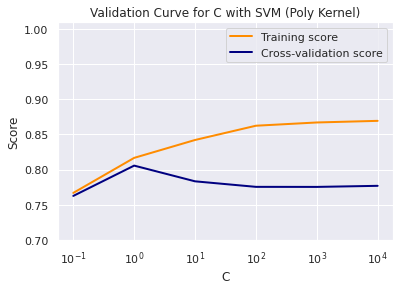

In [ ]:
plot_validation_curve(
    SVC(kernel='poly'), 
    "Validation Curve for C with SVM (Poly Kernel)", 
    X_train, 
    y_train, 
    param_name="C", 
    param_range=[0.1, 1, 10, 100, 1000, 10000], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=True,
    save_as=f"./plots/{dataset_name}/svc_poly_validation_curve_c.png"
)

Tune degree

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

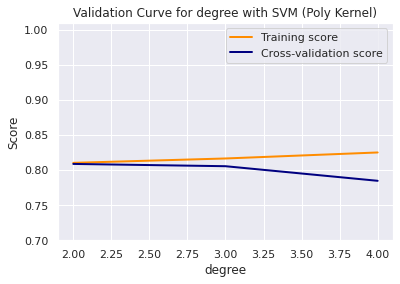

In [ ]:
plot_validation_curve(
    SVC(kernel='poly'), 
    "Validation Curve for degree with SVM (Poly Kernel)", 
    X_train, 
    y_train, 
    param_name="degree", 
    param_range=[2, 3, 4], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/svc_poly_validation_curve_degree.png"
)

Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

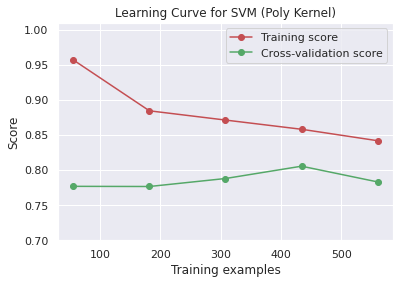

In [ ]:
plot_learning_curve(
    SVC(kernel='poly', C=10, degree=3), 
    "Learning Curve for SVM (Poly Kernel)", 
    X_train, 
    y_train, 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    n_jobs=4,
    save_as=f"./plots/{dataset_name}/svc_poly_learning_curve.png"
)

Train

In [ ]:
svc_poly = SVC(kernel='poly', C=10, degree=3)

clear_output()

start = time.time()
dtree = svc_poly.fit(X_train, y_train)
end = time.time()
print(end - start)

0.026060819625854492


## RBF Kernel

Tune the hyperparameter C, the regularization parameter

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

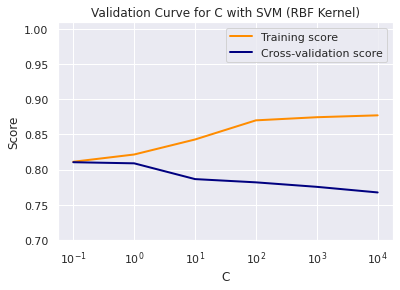

In [ ]:
plot_validation_curve(
    SVC(kernel='rbf'), 
    "Validation Curve for C with SVM (RBF Kernel)", 
    X_train, 
    y_train, 
    param_name="C", 
    param_range=[0.1, 1, 10, 100, 1000, 10000], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=True,
    save_as=f"./plots/{dataset_name}/svc_rbf_validation_curve_c.png"
)

Tune the hyperparameter gamma

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

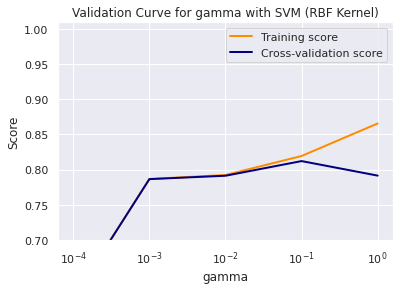

In [ ]:
plot_validation_curve(
    SVC(kernel='rbf'), 
    "Validation Curve for gamma with SVM (RBF Kernel)", 
    X_train, 
    y_train, 
    param_name="gamma", 
    param_range=[1, 0.1, 0.01, 0.001, 0.0001], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=True,
    save_as=f"./plots/{dataset_name}/svc_rbf_validation_curve_gamma.png"
)

Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

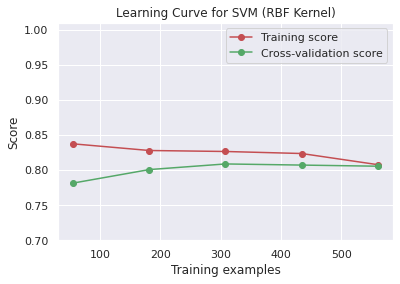

In [ ]:
plot_learning_curve(
    SVC(kernel='rbf', C=10, gamma=0.01), 
    "Learning Curve for SVM (RBF Kernel)", 
    X_train, 
    y_train, 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    n_jobs=4,
    save_as=f"./plots/{dataset_name}/svc_rbf_learning_curve.png"
)

Train

In [ ]:
svc_rbf = SVC(kernel='rbf', C=100, gamma=0.01)

# clear output
from IPython.display import clear_output 
clear_output()

start = time.time()
dtree = svc_rbf.fit(X_train, y_train)
end = time.time()
print(end - start)

0.02939605712890625


## Test

In [ ]:
for name, clf in zip(['poly', 'rbf'], [svc_poly, svc_rbf]):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} kernel test accuracy: {acc}")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print("Confusion matrix:")
    print(cm)
    print()

poly kernel test accuracy: 0.8059701492537313
Confusion matrix:
[[143  22]
 [ 30  73]]

rbf kernel test accuracy: 0.8097014925373134
Confusion matrix:
[[146  19]
 [ 32  71]]



# K-Nearest Neighbors

## Tune hyperparameters

Tune the distance metric

In [ ]:
param_grid = {"metric": ['euclidean', 'manhattan'], "n_neighbors": [3, 5, 7, 11, 19]}
grid_search, results_df = find_best_params(KNeighborsClassifier(), X_train, y_train, param_grid, cv=K_FOLDS)
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

Best parameters {'metric': 'euclidean', 'n_neighbors': 5}
Training accuracy: 0.8491171749598716
Cross-validation accuracy: 0.8057603686635945


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
euclidean_5,"{'metric': 'euclidean', 'n_neighbors': 5}",1,0.805760,0.055602
manhattan_7,"{'metric': 'manhattan', 'n_neighbors': 7}",1,0.805760,0.059976
euclidean_7,"{'metric': 'euclidean', 'n_neighbors': 7}",3,0.802535,0.064051
euclidean_11,"{'metric': 'euclidean', 'n_neighbors': 11}",4,0.802458,0.060583
manhattan_11,"{'metric': 'manhattan', 'n_neighbors': 11}",5,0.797670,0.056130
manhattan_5,"{'metric': 'manhattan', 'n_neighbors': 5}",6,0.794470,0.055484
manhattan_19,"{'metric': 'manhattan', 'n_neighbors': 19}",7,0.792883,0.030416
euclidean_3,"{'metric': 'euclidean', 'n_neighbors': 3}",8,0.792806,0.063783
euclidean_19,"{'metric': 'euclidean', 'n_neighbors': 19}",8,0.792806,0.043451


Tune the hyperparameter k, the number of nearest neighbors

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

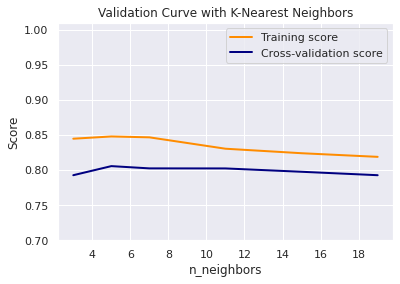

In [ ]:
plot_validation_curve(
    KNeighborsClassifier(), 
    "Validation Curve with K-Nearest Neighbors", 
    X_train, 
    y_train, 
    param_name="n_neighbors", 
    param_range=[3, 5, 7, 11, 15, 19], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/knn_validation_curve_k.png"
)

## Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

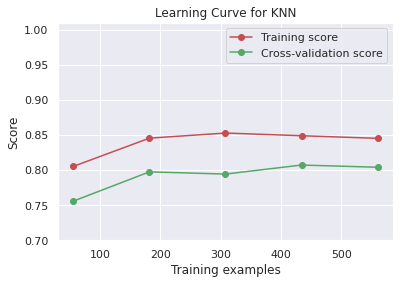

In [ ]:
plot_learning_curve(
    KNeighborsClassifier(n_neighbors=7, metric='euclidean'), 
    "Learning Curve for KNN", 
    X_train, 
    y_train, 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    n_jobs=4,
    save_as=f"./plots/{dataset_name}/knn_learning_curve.png"
)

In [ ]:
# title = "Performance of KNN"
# plot_fit_time_vs_score(
#     estimator, X_train, y_train, title=title, ylim=(0.7, 1.01), cv=n_folds, n_jobs=4
# )

## Train and test

In [ ]:
train_and_test(KNeighborsClassifier(n_neighbors=7, metric='euclidean'))

training time in seconds 0.007283926010131836
test accuracy: 0.8134328358208955
Confusion matrix:
[[144  21]
 [ 29  74]]


# Decision Tree

In [ ]:
# param_grid = {"max_depth": [2, 3, 5, 7, 10, 14], "min_samples_leaf": list(range(1, 15))}
# grid_search, results_df = find_best_params(DecisionTreeClassifier(), X_train, y_train, param_grid, cv=K_FOLDS)
# results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

## Tune hyperparameters

Tune max_depth

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

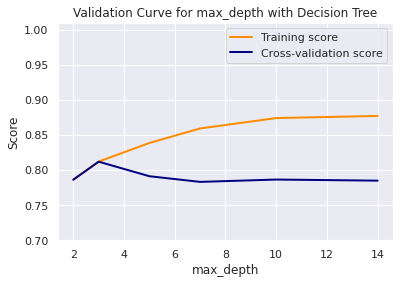

In [ ]:
plot_validation_curve(
    DecisionTreeClassifier(),
    "Validation Curve for max_depth with Decision Tree", 
    X_train, 
    y_train, 
    param_name="max_depth", 
    param_range=[2, 3, 5, 7, 10, 14], 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/dtree_validation_curve_max_depth.png"
)

Tune min_samples_leaf

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

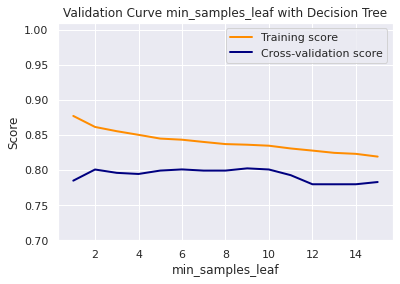

In [ ]:
plot_validation_curve(
    DecisionTreeClassifier(),
    "Validation Curve min_samples_leaf with Decision Tree", 
    X_train, 
    y_train, 
    param_name="min_samples_leaf", 
    param_range=list(range(1, 16)), 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/dtree_validation_curve_min_samples_leaf.png"
)

## Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

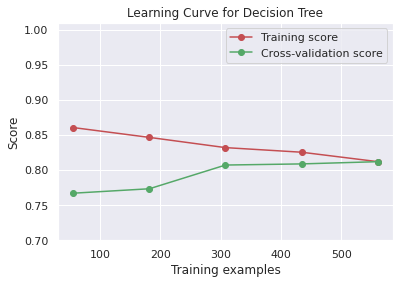

In [ ]:
plot_learning_curve(
    DecisionTreeClassifier(max_depth=3, min_samples_leaf=1), 
    "Learning Curve for Decision Tree", 
    X_train, 
    y_train, 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    n_jobs=4,
    save_as=f"./plots/{dataset_name}/dtree_learning_curve.png"
)

In [ ]:
# estimator = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)
# title = "Performance of Decision Tree"
# plot_fit_time_vs_score(
#     estimator, X_train, y_train, title=title, ylim=(0.7, 1.01), cv=K_FOLDS, n_jobs=4
# )

## Train and test

In [ ]:
train_and_test(DecisionTreeClassifier(max_depth=5, min_samples_leaf=1))

training time in seconds 0.006344795227050781
test accuracy: 0.8134328358208955
Confusion matrix:
[[144  21]
 [ 29  74]]


# Decision Tree with AdaBoost

## Tune hyperparameters

Tune learning rate

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

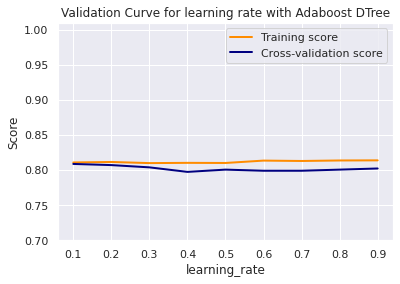

In [ ]:
plot_validation_curve(
    AdaBoostClassifier(),
    "Validation Curve for learning rate with Adaboost DTree", 
    X_train, 
    y_train, 
    param_name="learning_rate", 
    param_range=np.arange(0.1, 1, 0.1).tolist(), 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/boosting_validation_curve_learning_rate.png"
)

Tune n_estimators

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

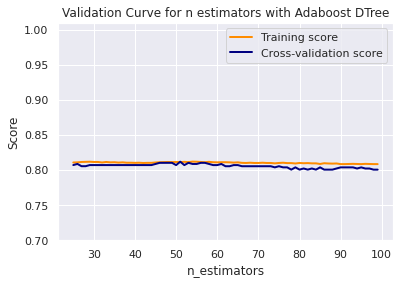

In [ ]:
plot_validation_curve(
    AdaBoostClassifier(learning_rate=0.2), 
    "Validation Curve for n estimators with Adaboost DTree", 
    X_train, 
    y_train, 
    param_name="n_estimators", 
    param_range=list(range(25, 100)), 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    use_semilogx=False,
    save_as=f"./plots/{dataset_name}/boosting_validation_curve_n_estimators.png"
)

## Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

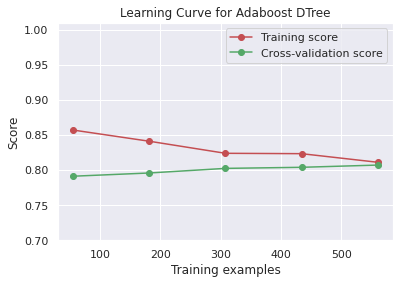

In [ ]:
plot_learning_curve(
    AdaBoostClassifier(learning_rate=0.2, n_estimators=30), 
    "Learning Curve for Adaboost DTree", 
    X_train, 
    y_train, 
    ylim=(0.7, 1.01), 
    cv=K_FOLDS, 
    n_jobs=4,
    save_as=f"./plots/{dataset_name}/boosting_learning_curve.png"
)

In [ ]:
# title = "Performance of Decision Tree"
# plot_fit_time_vs_score(
#     estimator, X_train, y_train, title=title, ylim=(0.7, 1.01), cv=n_folds, n_jobs=4
# )

## Train and test

In [ ]:
train_and_test(AdaBoostClassifier(learning_rate=0.3, n_estimators=50))

training time in seconds 0.00446009635925293
test accuracy: 0.8134328358208955
Confusion matrix:
[[144  21]
 [ 29  74]]


# Multilayer Perceptron

## Tune hyperparameters

Tune learning_rate

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

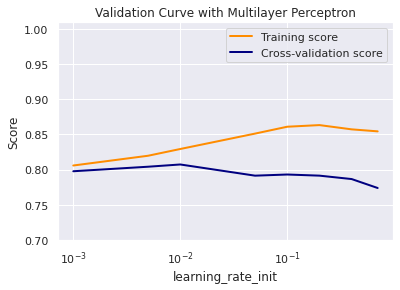

In [ ]:
estimator = MLPClassifier(random_state=1, solver='sgd')

title = "Validation Curve with Multilayer Perceptron"
param_name = "learning_rate_init"
# param_range = np.arange(0.001, 0.01, 0.001).tolist()
param_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.7]

fig = None

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=ConvergenceWarning, module="sklearn"
    )
    fig = plot_validation_curve(
        estimator, title, X_train, y_train, param_name, param_range, ylim=(0.7, 1.01), cv=K_FOLDS, use_semilogx=True
    )
    plt.savefig(f"./plots/{dataset_name}/mlp_validation_curve_lr.png")

fig

Tune hidden_layer_sizes

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

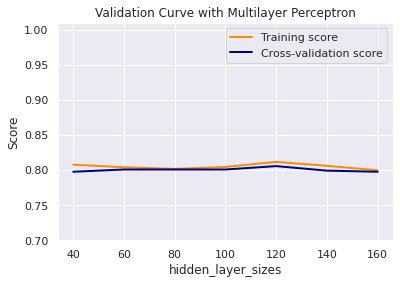

In [ ]:
estimator = MLPClassifier(random_state=1, learning_rate_init=0.001, solver='sgd')

title = "Validation Curve with Multilayer Perceptron"
param_name = "hidden_layer_sizes"
param_range = [(n,) for n in range(40, 161, 20)]

fig = None

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=ConvergenceWarning, module="sklearn"
    )
    fig = plot_validation_curve(
        estimator, title, X_train, y_train, param_name, param_range, ylim=(0.7, 1.01)
    )
    plt.savefig(f"./plots/{dataset_name}/mlp_validation_curve_hidden_layers.png")

fig

## Plot learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

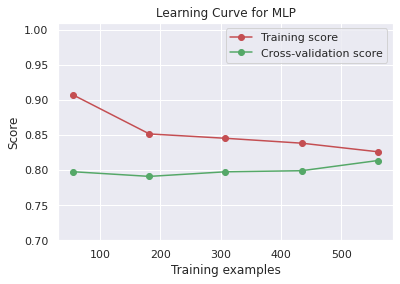

In [ ]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(120,), learning_rate_init=0.01, solver='sgd')

title = "Learning Curve for MLP"
fig = plot_learning_curve(
    mlp, title, X_train, y_train, ylim=(0.7, 1.01), cv=K_FOLDS, n_jobs=4
)
plt.savefig(f"./plots/{dataset_name}/mlp_learning_curve.png")
fig

In [ ]:
# title = "Performance of MLP"
# plot_fit_time_vs_score(
#     mlp, X_train, y_train, title=title, ylim=(0.7, 1.01), cv=K_FOLDS, n_jobs=4
# )

## Plot loss curve

In [ ]:
# mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,), learning_rate_init=0.001)

# with warnings.catch_warnings():
#     warnings.filterwarnings(
#         "ignore", category=ConvergenceWarning, module="sklearn"
#     )
#     mlp.fit(X_train, y_train)
#     # cv_results = cross_validate(mlp, X_train, y_train, cv=n_folds)
#     # print(sorted(cv_results.keys()))

# plt.title("Loss Curve for Multilayer Perceptron")
# plt.plot(mlp.loss_curve_)

In [ ]:
# lrs = [0.001, 0.005, 0.1, 0.2]
# mlps = []
# for lr in lrs:
#     mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,), learning_rate_init=lr)
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             "ignore", category=ConvergenceWarning, module="sklearn"
#         )
#         mlp.fit(X_train, y_train)
#     mlps.append(mlp)


# fig, ax = plt.subplots()
# plt.title("Loss Curve for Multilayer Perceptron")
# for mlp, lr in zip(mlps, lrs):
#     ax.plot(mlp.loss_curve_, label=f"learning_rate_init = {lr}")
# ax.legend(loc="best")

In [ ]:
# n_hidden_layers = list(range(50, 151, 20))
# mlps = []
# for n in n_hidden_layers:
#     mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(n,), learning_rate_init=0.005)
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             "ignore", category=ConvergenceWarning, module="sklearn"
#         )
#         mlp.fit(X_train, y_train)
#     mlps.append(mlp)


# fig, ax = plt.subplots()
# plt.title("Loss Curve for Multilayer Perceptron")
# for mlp, n in zip(mlps, n_hidden_layers):
#     ax.plot(mlp.loss_curve_, label=f"hidden_layers = {n}")
# ax.legend(loc="best")

## Train and test

In [ ]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(120,), learning_rate_init=0.01, solver='sgd')
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=ConvergenceWarning, module="sklearn"
    )
    mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"test accuracy: {acc}")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm

test accuracy: 0.8171641791044776


array([[149,  16],
       [ 33,  70]])

In [ ]:
# !cp -r plots/$dataset_name/*.png /content/gdrive/MyDrive/plots/$dataset_name